# Исследование зависимости успеха игры от разных факторов

Необходимо изучить данные об играх, выпущенных с 1980 по 2016 год. В датасете содержится различная информация об игре, начиная с платформы, на которой игра была доступна, и заканчивая оценками пользователей и критиков. Все эти данные помогут сформировать вывод о том, какой продукт будет наиболее актуальным в 2017 году.

## Импорт необходимых библиотек и открытие датасета

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

В начале проекта сразу импортируем все возможные библиотеки, которые нам пригодятся:
- **pandas** - работа с датасетами
- **scipy.stats** - проверка гипотез
- **numpy** - в данном проекте будет использоваться лишь в качестве извлечения NaN значения из этой библиотеки
- **matplotlib.pyplot** и **seaborn** - построение графиков

In [2]:
data = pd.read_csv('games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датасет был сохранен в переменной `data`. Она и будет выступать в качестве основной для исследования. Но перед исследованием нужно тщательно изучить данные и в случае необходимости подготовить их к работе.

## Предобработка данных

При вызове метода `.info()` обнаружено отсутствие змеиного регистра - это можно сразу исправить.

In [4]:
data = data.rename(columns = {'Name':'name',
                              'Platform':'platform',
                             'Year_of_Release':'year_of_release',
                             'Genre':'genre',
                             'NA_sales':'na_sales',
                             'EU_sales':'eu_sales',
                             'JP_sales':'jp_sales',
                             'Other_sales':'other_sales',
                             'Critic_Score':'critic_score',
                             'User_Score':'user_score',
                             'Rating':'rating'})

Теперь можно ознакомиться с датасетом:

In [5]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Следует заняться заполнением пропусков. Начнем с года выпуска игры:

In [6]:
data.loc[data['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Таких пропусков немного, но они есть. Из приведенной выше части датасета можно сделать вывод, что у части игр год указан в названии. Но это не совсем так. Как правило, производители игр пишут в названии следующий год после года выпуска (т.е. не 2004, а 2003). Также может быть такое, что на одной платформе игра вышла в 2004 году, а на другой эта же игра, допустим, вышла в 2005. 

Постараемся учесть все эти факторы и проведем заполнение в 3 этапа:
- Сначала поищем, есть ли такие же игры в датасете с указанным годом выпуска. Их может быть много (т.к. платформ много), поэтому заполним пропуск в этом случае медианой по остальным играм
- Затем играм, у которых в названии указан год, присвоим год выпуска на год меньше
- После этого оставшуюся часть пропусков заполним медианным значением года выпуска для платформы, на которой вышла игра

In [7]:
for row in data.loc[data['year_of_release'].isna(),:].index:
    if data.loc[data['name']==data.loc[row,'name']].shape[0]>1:
        data.loc[(data['name']==data.loc[row,'name']) & (data['year_of_release'].isna()),'year_of_release'] = \
        data.loc[(data['name']==data.loc[row,'name']) & ~(data['year_of_release'].isna()),'year_of_release'].median()
        
for year in range(1980,2017):
    data.loc[(data['year_of_release'].isna()) & (data['name'].str.find(str(year))>-1),'year_of_release'] = year-1
    
for row in data.loc[data['year_of_release'].isna(),:].index:
    data.loc[row,'year_of_release'] = data.loc[data['platform']==data.loc[row,'platform'],'year_of_release'].median()

После того, как все пропуски в этом столбце заполнены, можно изменить его тип, чтобы он соответствовал дате.

In [8]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'],format='%Y')

In [9]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Следующий столбец, в котором есть пропуски, - это `user_score`. Здесь заполнить пропуски не получится по нескольким причинам:
- Возможно, игра не получила оценок ввиду отсутствия популярности
- Возможно, данные об оценках просто не подгружены в датасет
В пользу второй теории можно отметить значения `tbd` в столбце, что означает *to be determined - т.е. будет определено*.
В любом случае, оценка - понятние субъективное, и даже очень продаваемая игра может иметь низкие оценки, либо, наоборот непопулярная игра соберет только положительные отзывы.
В связи с этим принято решение оставить, как есть, за исключением исправления `tbd` на `NaN`.

In [10]:
data.loc[data['user_score']=='tbd','user_score'] = np.nan
data['user_score'] = data['user_score'].astype('float')

Заодно изменили тип столбца со строчного на вещественный.

In [11]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Есть и 2 пропуска в имени игры. Они совпадают с пропуском в жанре. С такими данными можно смело распрощаться, поскольку влияния на общую картину они не окажут.

In [12]:
data = data.loc[~data['name'].isna()].reset_index(drop=True)

In [13]:
data['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Столбец с оценками критиков не будет заполнен по тем же причинам, что и столбец с оценками пользователей. Здесь еще можно добавить, что, возможно, не каждая игра попадает под ревью профессионалов. 

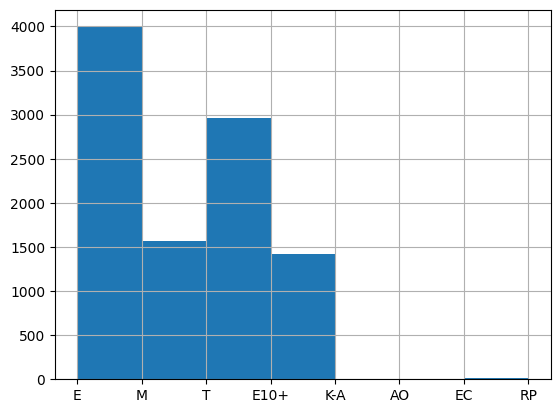

In [14]:
data['rating'].hist(bins=7);

Теперь стоит разобраться с рейтингом игр. Буквы обозначают различные возрастные ограничения. **Е** - игры без ограничений по возрасту. Как можно заметить, таких большинство. 

Есть одна особенность - рейтинг ESRB появился в 1994 году, а данные в датасете представлены начиная с 1980. То есть, часть игр физически не имеет этого рейтинга (либо можно сказать, что на них нет возрастных ограничений). 

Но если обратить внимание на распределение пропусков по регионам, можно обнаружить одну особенность:

In [15]:
data_demo = data.melt(id_vars=['rating'], value_vars=['na_sales','eu_sales','jp_sales','other_sales'])
data_demo = data_demo[data_demo['value'] > 0]
data_demo.groupby('variable').agg({'rating' : lambda x : x.isna().mean()})

,rating
variable,
eu_sales,0.279233
jp_sales,0.644677
na_sales,0.248484
other_sales,0.252250


Получается, что в Японии пропусков больше всего. В связи с этим сделаем отдельную пометку для игр, где не указан рейтинг:

In [16]:
data['rating'] = data['rating'].fillna('N/A')

Предобработка выполнена, теперь добавим столбец с суммой продаж со всех стран у игры.

In [17]:
data['total_sales'] = data['na_sales']+data['jp_sales']+data['eu_sales']+data['other_sales']

Вот, что в итоге получилось:

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16713 non-null  object        
 1   platform         16713 non-null  object        
 2   year_of_release  16713 non-null  datetime64[ns]
 3   genre            16713 non-null  object        
 4   na_sales         16713 non-null  float64       
 5   eu_sales         16713 non-null  float64       
 6   jp_sales         16713 non-null  float64       
 7   other_sales      16713 non-null  float64       
 8   critic_score     8137 non-null   float64       
 9   user_score       7590 non-null   float64       
 10  rating           16713 non-null  object        
 11  total_sales      16713 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 1.5+ MB


Присутствует змеиный регистр, типы данных соответствуют значениям в столбцах, пропуски по возможности заполнены. Предобработка выполнена успешно.

## Исследовательский анализ данных

Начнем исследование с изучения числа выпущенных игр по годам.

C:\Users\yaasd\AppData\Local\Temp\ipykernel_1576\1846058866.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(1979,2017));


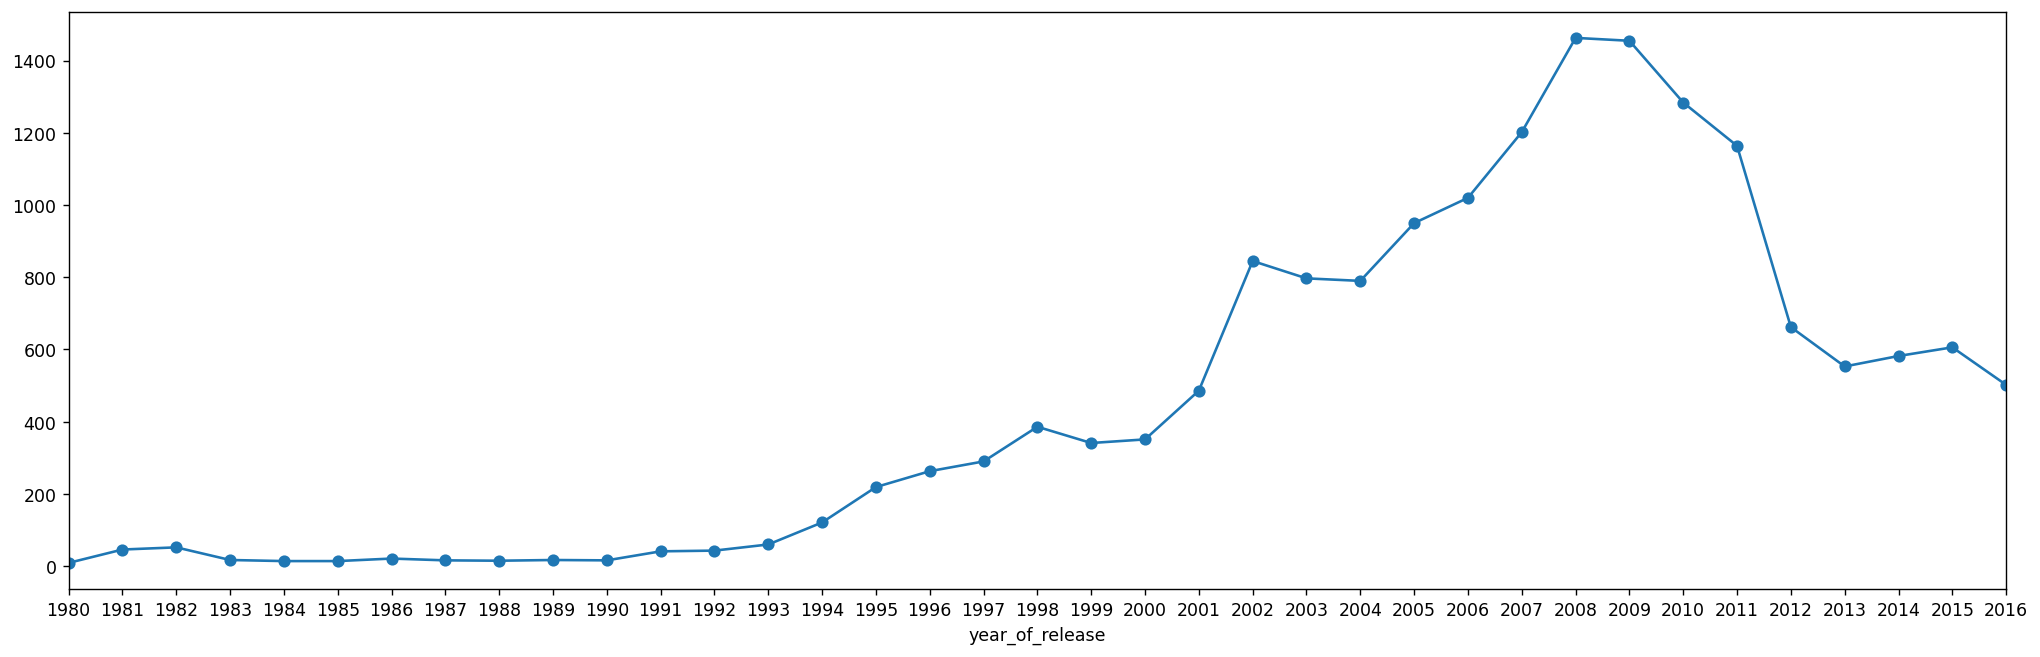

In [19]:
from matplotlib import dates
import matplotlib.ticker as ticker

plt.figure(figsize=(20,6), dpi=125)
ax = data.groupby('year_of_release')['year_of_release'].count().plot(style = 'o-');
plt.gcf().canvas.draw()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(range(1979,2017));

Из графика видно, что за первые 20 лет выпускалось не более 500 игр каждый год. Далее, по всей видимости, это направление получило широкое распространение, и стали производить больше подобного контента. Ввиду этого можно считать, что до 2000-ого года выборка нерепрезентативна, поэтому данные могут быть не правдоподобны (грубо говоря, тогда у людей практически не было выбора, и они покупали то, что было доступно).

Далее посмотрим на графики продаж у самых успешных платформ. Будем считать, что успешная платформа, - это та, которая за все время заработала более 400 млн.

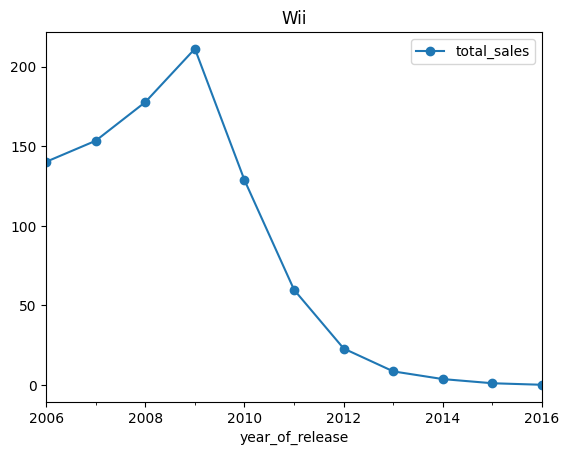

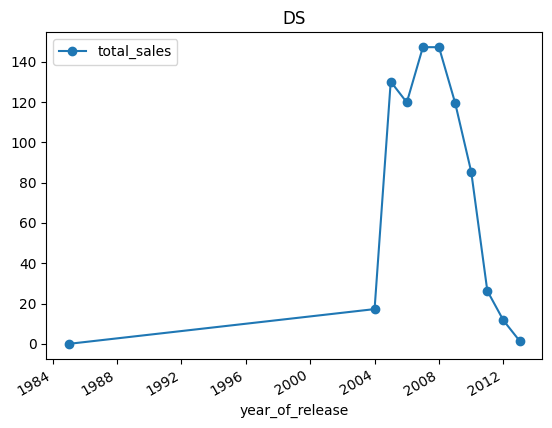

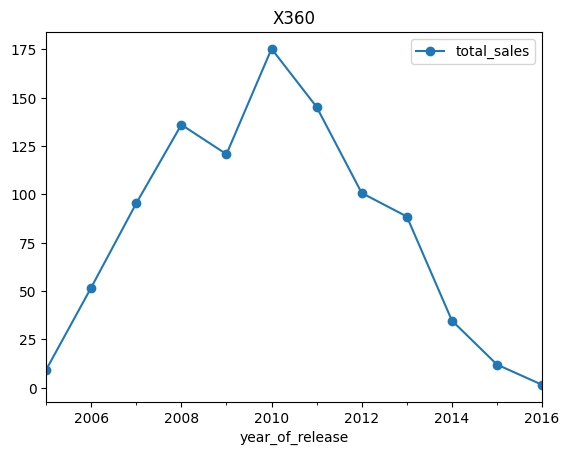

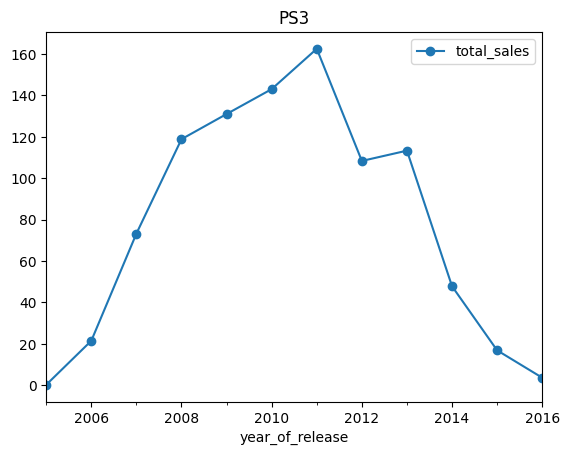

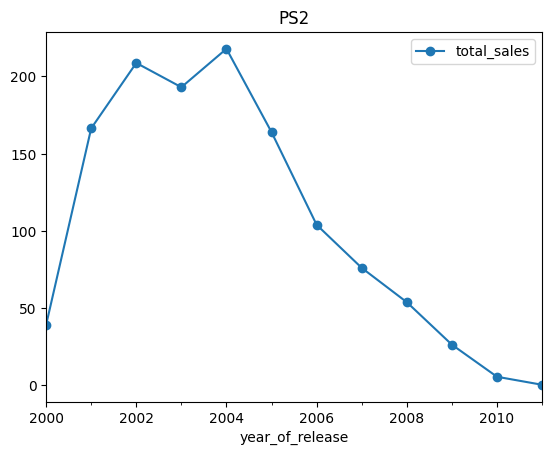

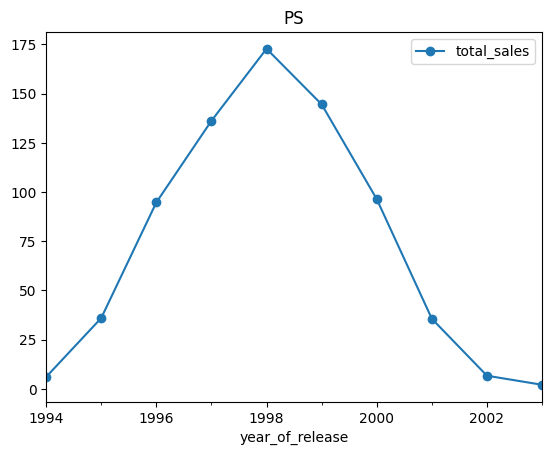

In [20]:
top_sales = data.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum').reset_index()
for i in data['platform'].unique():
    if top_sales.loc[top_sales['platform']==i,'total_sales'].sum()>400:
        top_sales.loc[top_sales['platform']==i,:].plot('year_of_release','total_sales',style='o-')
        plt.title(i)


Из вышеприведенных графиков можно сделать вывод, что игровая платформа живет не более 10 лет. Пик успешности наступает через 4-6 лет, после чего продажи постепенно падают. Падение связано с тем, что через 6-7 лет после появления платформы на смену ей приходит новая, усовершенствованная. Так, например, PS появляется в 1994 году, показывает пик продаж в 1998, далее продажи падают и в 2000 году появляется PS2. Через 4 года у PS2 лучший год по сумме продаж, и разработчики, имея опыт с предыдущей платформой, в 2006 году показывают модернизированную PS3 и т.д.

Пока старая платформа приносит определенный доход, ее не выводят из эксплуатации.

Итак, для построения прогноза необходимо выбрать актуальный период, за который будут исследоваться данные.
Учитывая, что платформа, в среднем, живет около 10 лет, это нельзя назвать актуальным периодом. Так в исследование попадет слишком много лишних данных. Брать период, за который платформа добивается наибольшей популярности, тоже не совсем правильно, ведь, допустим, в 2010-2011 платформа могла быть на пике продаж, а к 2016 уже утратила свою актуальность.

Поэтому лучше всего взять период не более 4 лет. Так утратившие актуальность платформы будут сразу заметны по падающей сумме продаж ежегодно, а набирающие популярность, наоборот, будут выделяться растущей линией на координатной плоскости.

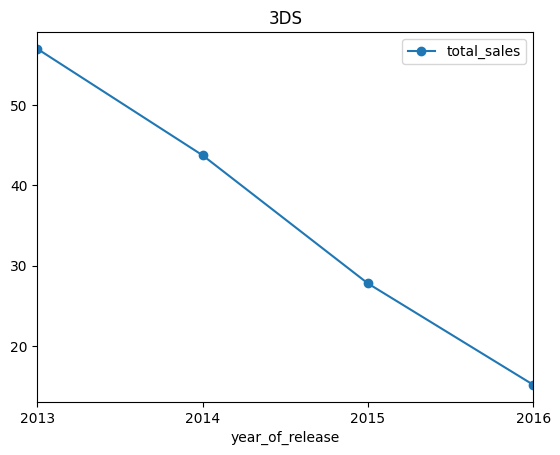

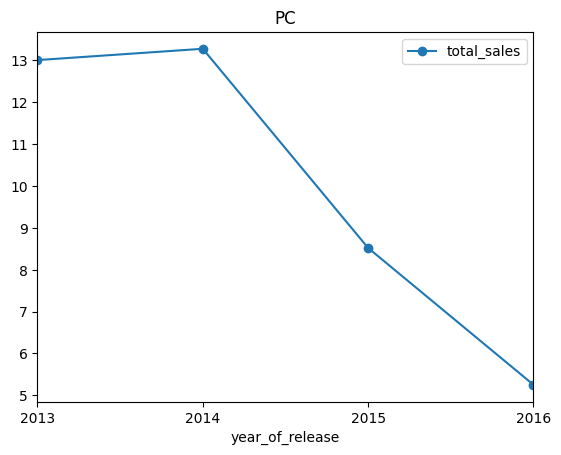

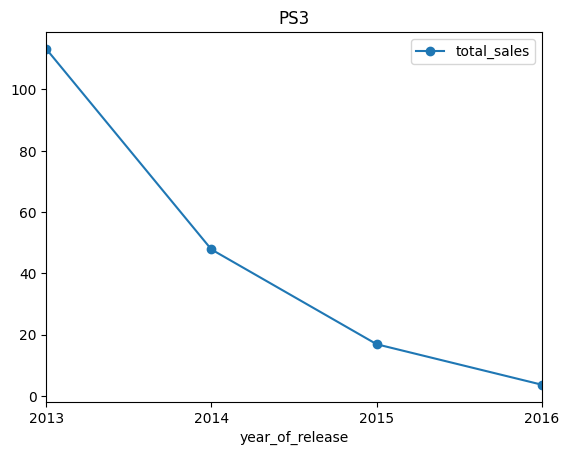

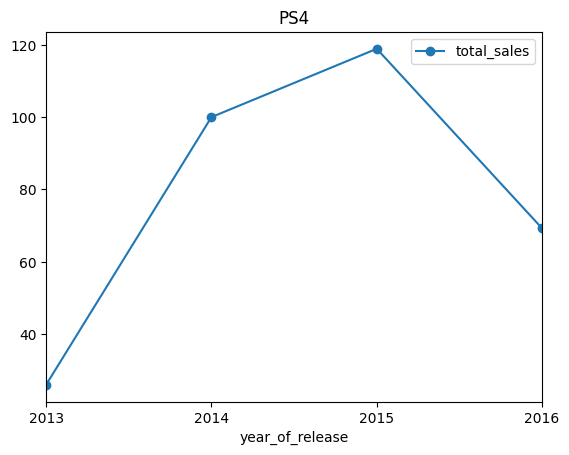

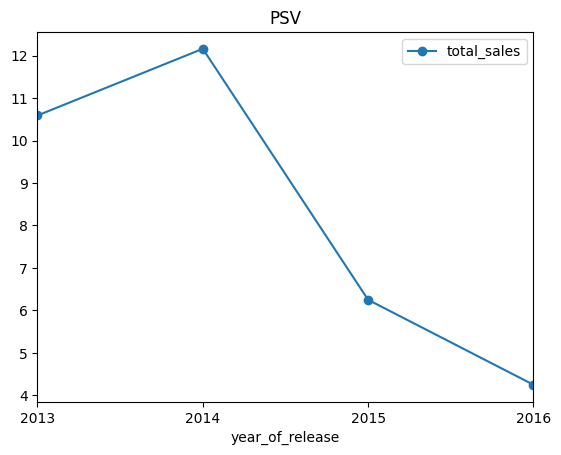

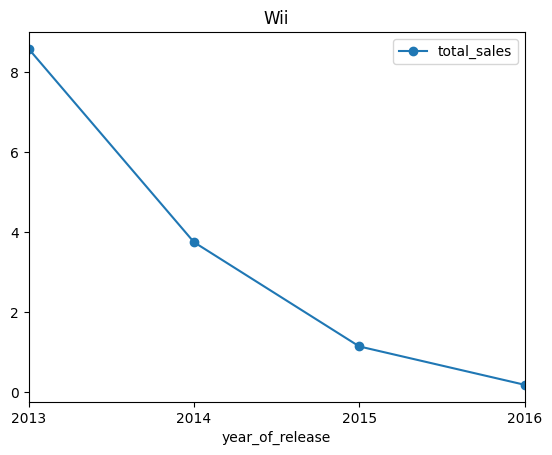

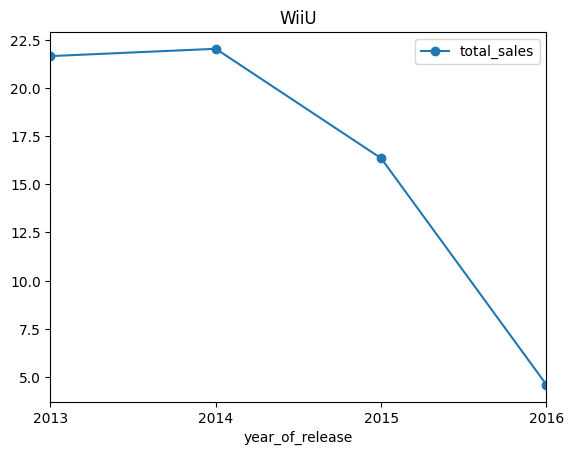

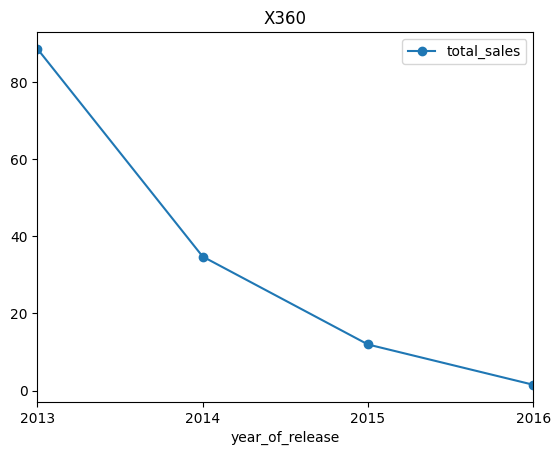

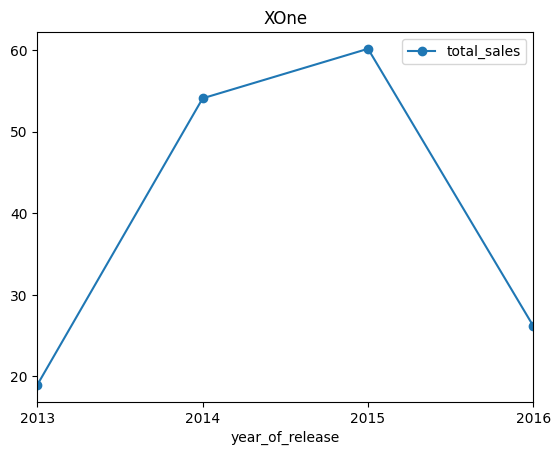

In [21]:
top_sales_actual = top_sales.loc[top_sales['year_of_release']>pd.to_datetime('2012'),:].reset_index(drop=True)
for i in top_sales_actual['platform'].unique():
    if top_sales_actual.loc[top_sales_actual['platform']==i,'total_sales'].sum()>10:
        top_sales_actual.loc[top_sales_actual['platform']==i,:].plot('year_of_release','total_sales',style='o-')
        plt.title(i)

Получили довольно много платформ. Но многие из них к 2016 году уже перестали существовать.

Также для более объективного исследования лучше опираться на 2015 год, поскольку при передаче датасета было отмечено, что данные за 2016 год могут быть неполными. Это действительно так, ведь по графикам нет ни одной платформы, у которой сумма продаж в 2016 году больше, чем в 2015.

Что тогда получается? Лишь XOne и PS4 остались актуальными к 2016 году. Даже на компьютере уже никто не хочет играть. Также можно выделить не особо популярную платформу WiiU, которая каждый год продает в сумме игр примерно на 20 млн. Либо это непопулярная платформа, либо она выпускает контент для ограниченного круга людей (например, только для взрослых или только для детей).

Для дальнейшего исследования потребуется создать новый датасет, в котором будут храниться только актуальные данные.

In [22]:
data_actual = data[data['year_of_release']>pd.to_datetime('2012')].reset_index(drop=True)

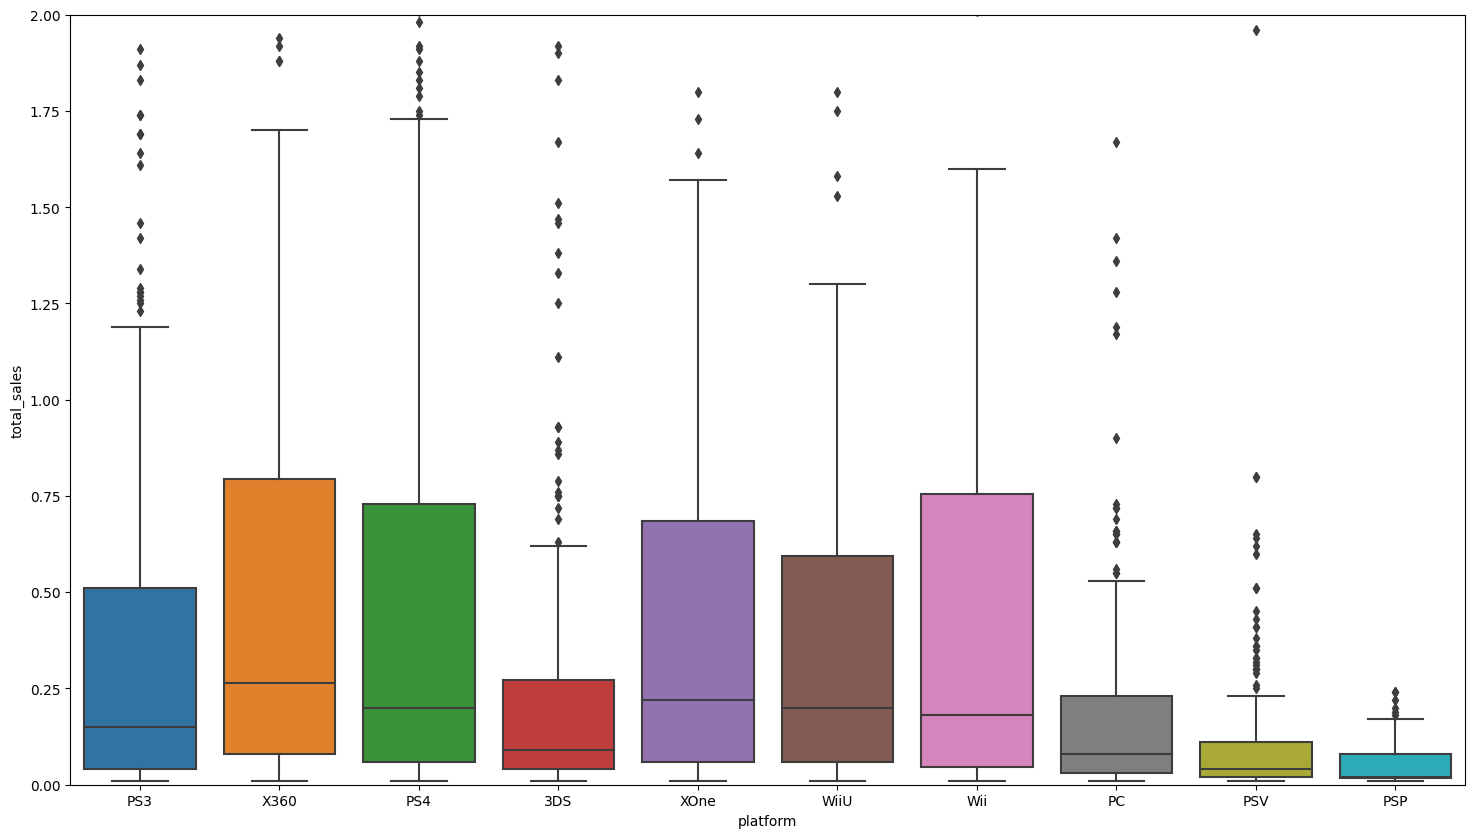

In [23]:
plt.figure(figsize=(18,10))
plt.ylim(0,2)
sns.boxplot(x=data_actual.loc[data_actual['platform']!='DS','platform'],y=data_actual.loc[:,'total_sales'],data=data_actual);

По ящику с усами можно выделить самые популярные платформы за последние 4 года. Можно сказать, что их 4 - PS3, PS4, X360 и XOne. PS3 является предшественником PS4, как и X360 с XOne. По сути, две фирмы стали монополистами в области продаж игр. Хоть графики и не наглядны из-за выбросов, четко видно, что медиана у PS4 уже даже сейчас больше, чем у PS3, хотя полные данные об этой платформе есть всего за 3 года, т.е., скорее всего, пик продаж будет позже. XOne так же появилась в 2013 году, но не добилась таких успехов. Значит, Sony - лидер в этой сфере.

Теперь посмотрим, как оценки критиков и пользователей влияют на продажи игр.

В исследовании будут участвовать самые успешные платформы, т.е. те, у которых за все время продаж было больше всего.

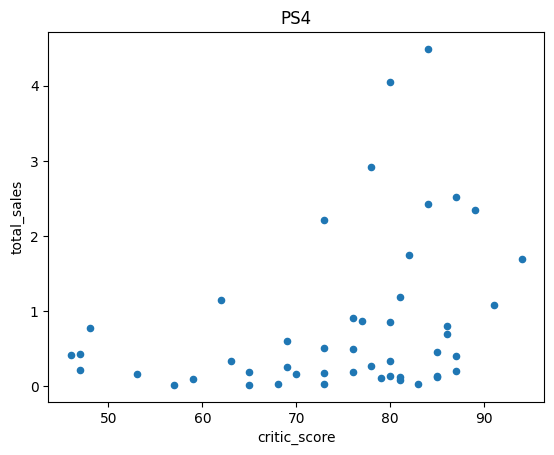

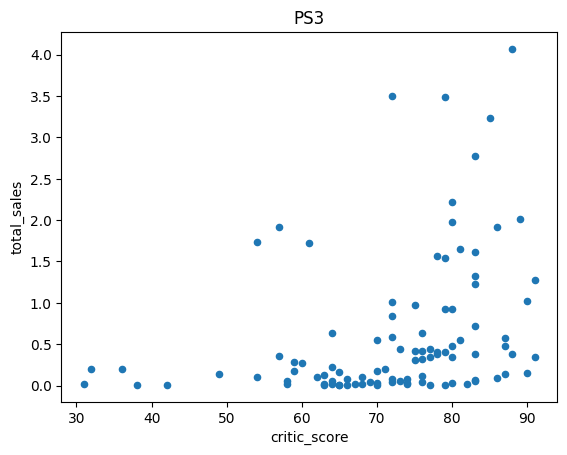

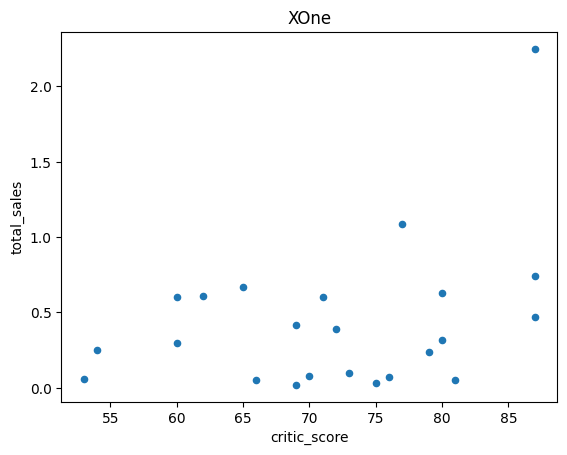

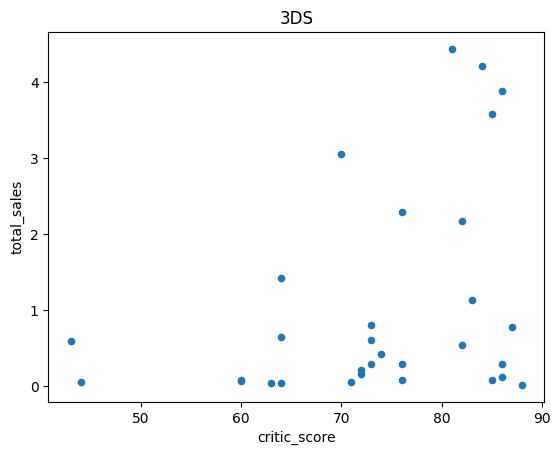

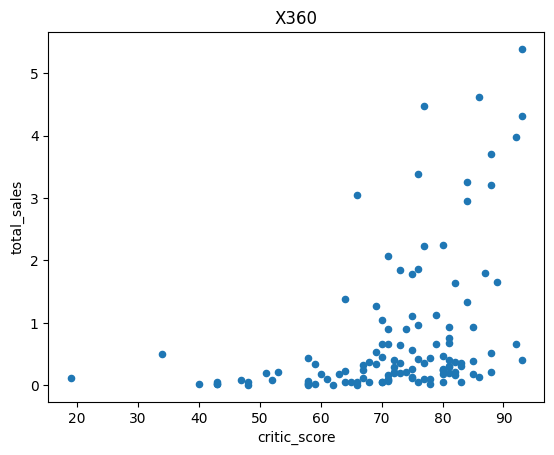

In [24]:
for i in data_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:5]:
    data_actual.loc[data['platform']==i,['total_sales','critic_score']].plot('critic_score','total_sales',kind='scatter')
    plt.title(i)

У всех есть выбросы, где при хорошей оценке критиков продажи у игры высокие, но, в основном, оценки оказывают слабое влияние на продажи.

По аналогии посмотрим, какое влияние у оценок пользователей.

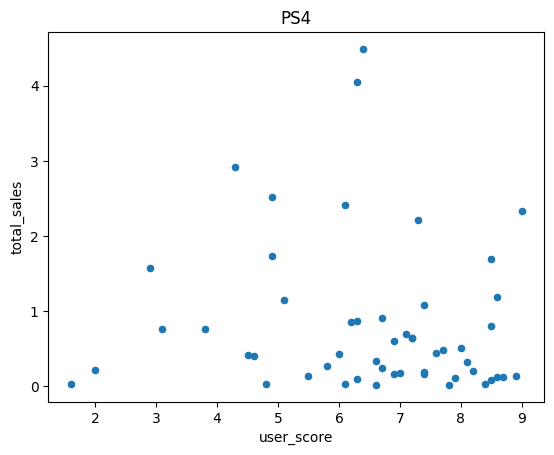

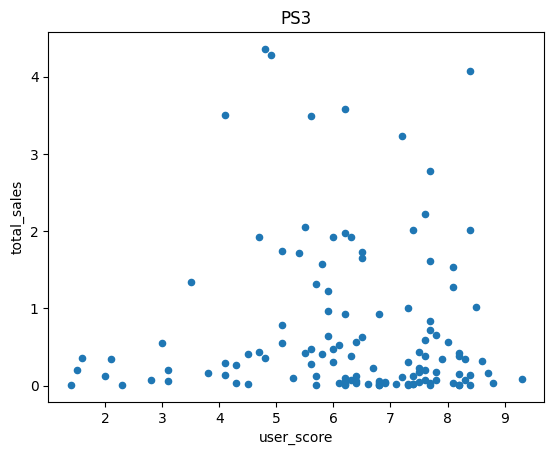

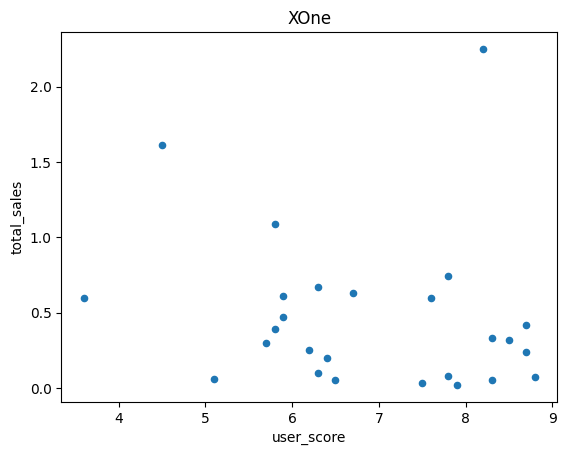

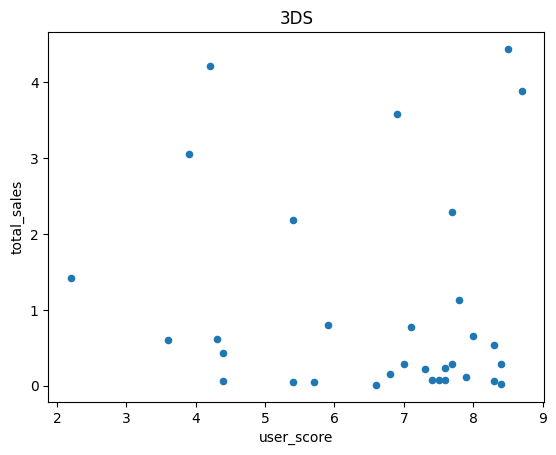

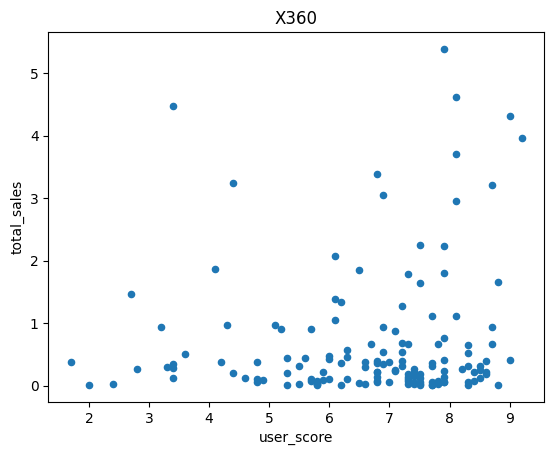

In [25]:
for i in data_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:5]:
    data_actual.loc[data['platform']==i,['total_sales','user_score']].plot('user_score','total_sales',kind='scatter')
    plt.title(i)

Опять же, есть исключение, но, в общем, здесь влияния еще меньше, чем у оценок критиков.

Чтобы подтвердить эту гипотезу, посмотрим на корреляцию. Здесь возьмем не 5 платформ, а 7.

In [26]:
print('Корреляция между оценками критиков и продажами игр')
for i in data_actual.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:7]:
    print(f'{i}\t{data_actual.loc[data["platform"]==i,"total_sales"].corr(data_actual.loc[data["platform"]==i,"critic_score"]).round(2)}')

Корреляция между оценками критиков и продажами игр
PS4	0.32
PS3	0.32
XOne	0.37
3DS	0.34
X360	0.41
WiiU	0.52
PC	0.4


Действительно, коэффициент корреляции не превышает 0.45, а это считается слабой корреляцией.

In [27]:
print('Корреляция между оценками пользователей и продажами игр')
for i in data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:7]:
    print(f'{i}\t{data.loc[data["platform"]==i,"total_sales"].corr(data.loc[data["platform"]==i,"user_score"]).round(2)}')

Корреляция между оценками пользователей и продажами игр
PS2	0.17
X360	0.11
PS3	0.13
Wii	0.11
DS	0.13
PS	0.3
GBA	0.1


Наглядная таблица корреляций:

In [28]:
data_actual.groupby('platform')[['user_score', 'critic_score']].corrwith(data_actual['total_sales']).round(2)

c:\users\yaasd\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\users\yaasd\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\users\yaasd\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\users\yaasd\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


,user_score,critic_score
platform,,
3DS,0.25,0.36
DS,NaN,NaN
PC,-0.09,0.20
PS3,0.00,0.33
PS4,-0.03,0.41
PSP,-1.00,NaN
PSV,0.00,0.26
Wii,0.68,NaN
WiiU,0.42,0.38


В случае оценок пользователей коэффициент корреляции еще ниже. Это говорит о том, что оценки пользователей практически никак не сказываются на продажах.

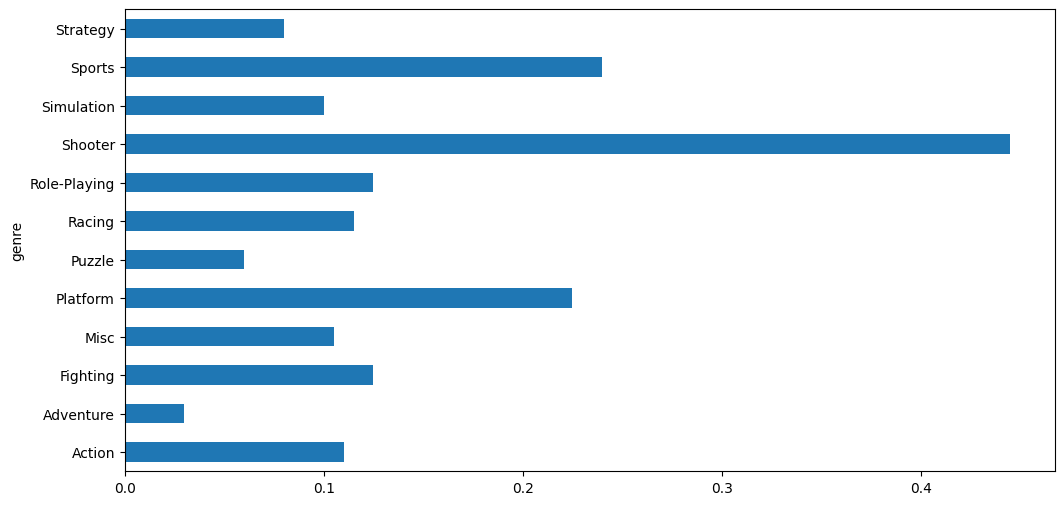

In [29]:
data_actual.groupby('genre')['total_sales'].median().plot(kind='barh',figsize=(12,6));

А из этого графика можно сказать, что 3 самых актуальных жанра - это шутер, спорт и платформа. И шутер уверенно лидирует.

## Портрет пользователя каждого региона

В этом блоке следует выяснить, где и какая платформа и жанр наиболее популярны.
Для этого нужно визуализировать данные.

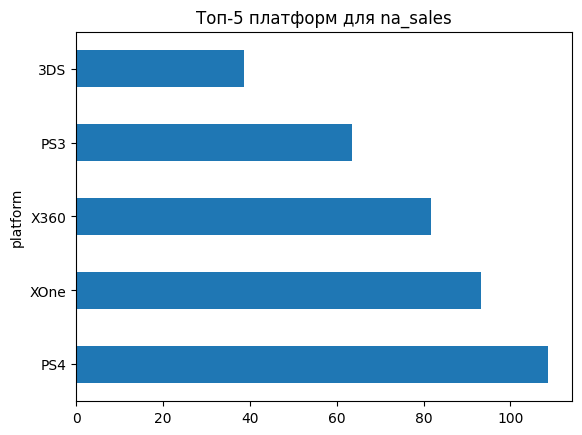

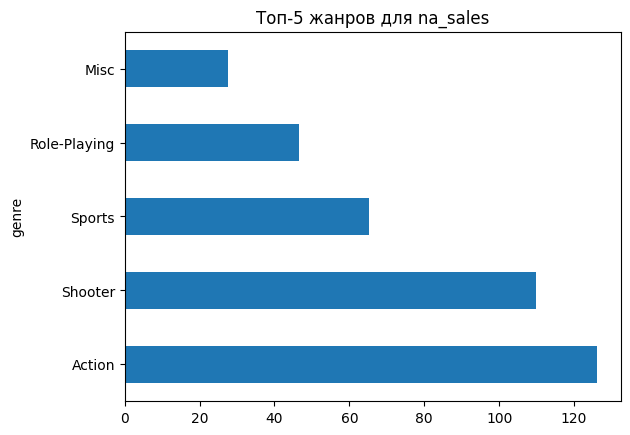

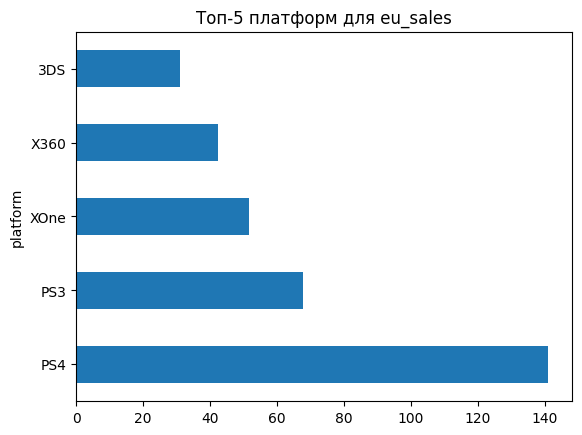

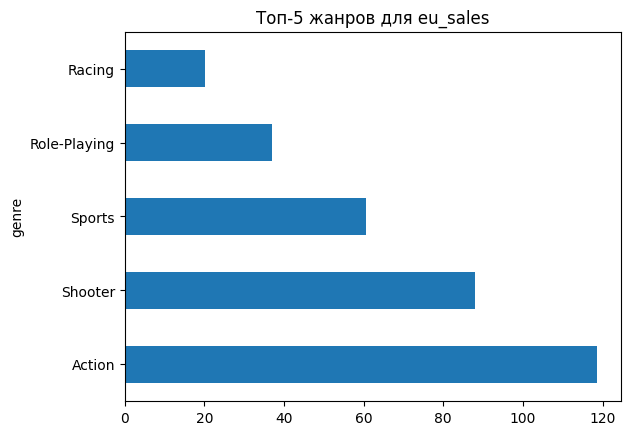

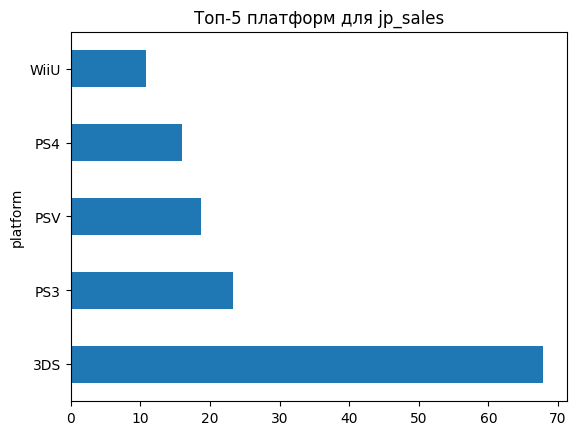

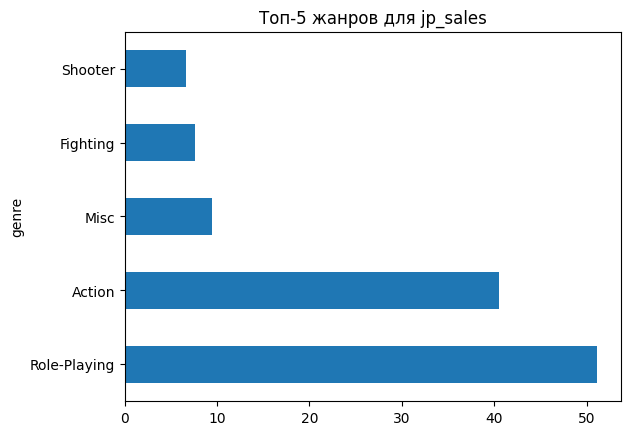

In [30]:
for i in ['na_sales','eu_sales','jp_sales']:
    
    data_actual.groupby('platform')[i].sum().sort_values(ascending=False).head().plot(kind='barh')
    plt.title(f'Топ-5 платформ для {i}')
    plt.show()
    
    data_actual.groupby('genre')[i].sum().sort_values(ascending=False).head().plot(kind='barh')
    plt.title(f'Топ-5 жанров для {i}')
    plt.show()

Есть несколько особенностей:
- набирающие популярность `XOne` и `PS4` уже заняли лидирующие позиции в Европе и Северной Америке. Видно, почему `XOne` отстает - в Европе отдают гораздо больше предпочтения конкуренту.
- Европа и Северная Америка очень схожи между собой по предпочтениям - рейтинги отличаются одним жанром. Платформы одни и те же. В японии ценится RP-жанр, в то время как другие регионы только недавно открыли его для себя.
- Япония сильно отличается от других регионов. Здесь совсем не получили распространение `PS3` и `X360`. Значит, и их наследники здесь вряд ли станут актуальны в 2017 году. Но и продаж в Японии гораздо меньше, чем в других регионах. Это связано как с численностью населения, так и с тем, что здесь больше всего любят *RP-игры*, в которые практически не играют в Европе и в Америке.

Теперь посмотрим на распределение процентного отношения продаж в регионах:

In [31]:
total_ratio = data_actual.loc[:,['na_sales','eu_sales','jp_sales','total_sales']].sum()
print(f'na_sales_ratio\t{round(total_ratio["na_sales"]/total_ratio["total_sales"],2)}')
print(f'eu_sales_ratio\t{round(total_ratio["eu_sales"]/total_ratio["total_sales"],2)}')
print(f'jp_sales_ratio\t{round(total_ratio["jp_sales"]/total_ratio["total_sales"],2)}')

na_sales_ratio	0.4
eu_sales_ratio	0.36
jp_sales_ratio	0.13


Северная Америка приносит больше всего дохода, Европа практически не отстает. А предпочтения по жанрам в Америке и в Европе одинаковые. Стоит обратить на это внимание при выпуске игры.

Также стоит проверить, как возрастные ограничения сказываются на продажах игр.

In [32]:
for i in data_actual['rating'].unique():
    ratio = data_actual.loc[data['rating']==i,['na_sales','eu_sales','jp_sales','total_sales']].sum()
    print(f'ESRB = {i}')
    print(f'na_sales_ratio\t{round(ratio["na_sales"]/ratio["total_sales"],2)}')
    print(f'eu_sales_ratio\t{round(ratio["eu_sales"]/ratio["total_sales"],2)}')
    print(f'jp_sales_ratio\t{round(ratio["jp_sales"]/ratio["total_sales"],2)}\n')

ESRB = M
na_sales_ratio	0.41
eu_sales_ratio	0.37
jp_sales_ratio	0.12

ESRB = N/A
na_sales_ratio	0.38
eu_sales_ratio	0.38
jp_sales_ratio	0.13

ESRB = E
na_sales_ratio	0.41
eu_sales_ratio	0.35
jp_sales_ratio	0.13

ESRB = T
na_sales_ratio	0.42
eu_sales_ratio	0.33
jp_sales_ratio	0.14

ESRB = E10+
na_sales_ratio	0.38
eu_sales_ratio	0.33
jp_sales_ratio	0.18



**RP** означает, что рейтинг еще не был получен и только ожидается. 
Исходя из этого можно сделать выводы, что в Японии больше всего ценятся игры, выпущенные под рейтингом **Е10+**, а в Северной Америке и в Европе возрастные ограничения практически не сказываются на продажах, т.к. выделение по жанрам показало примерно такое же распределение продаж по этим регионам.

В начале при построении графиков можно было увидеть, что таких игр единицы, но они очень ценятся аудиторией.

Представление информации в графическом виде:

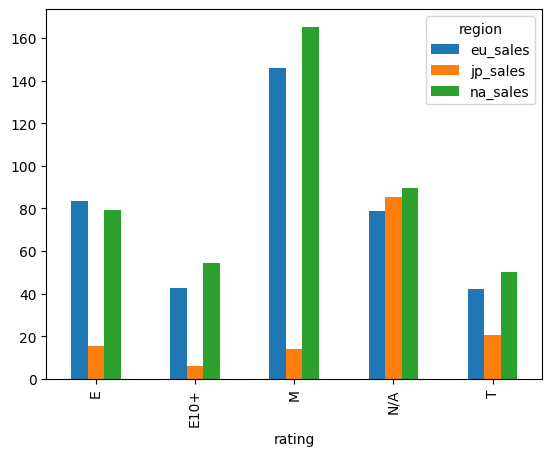

In [33]:
data_actual.melt(id_vars='rating', value_vars=['na_sales','eu_sales','jp_sales'], var_name='region') \
    .pivot_table(index='rating', columns='region', values='value', aggfunc='sum').plot(kind='bar');

## Проверка гипотез

Теперь перейдем к проверке гипотез.

Уровень значимости задан значением в 5%. При помощи метода `ttest_ind` из модуля `scipy.stats` проверим гипотезу о равенстве средних оценок пользоваталей. Поскольку приставка и компьютер - совершенно разные игровые платформы, то не стоит предполагать, что дисперсии оценок одинаковы.

In [34]:
results = st.ttest_ind(data_actual.loc[(data_actual['platform']=='XOne') & ~(data_actual['user_score'].isna()),'user_score']\
                       ,data_actual.loc[(data_actual['platform']=='PC')& ~(data_actual['user_score'].isna()),'user_score'],equal_var=False)
alpha = 0.05
print('H0: средние оценки пользователей платформ XOne и PC равны')
print('H1: средние оценки пользователей платформ XOne и PC не равны')
if results.pvalue<alpha:
    print(f'p-value = {results.pvalue} - отвергаем нулевую гипотезу')
else:
    print(f'p-value = {results.pvalue} - нет оснований отвергнуть нулевую гипотезу')

H0: средние оценки пользователей платформ XOne и PC равны
H1: средние оценки пользователей платформ XOne и PC не равны
p-value = 0.16174359801784316 - нет оснований отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута. Значит, средние оказались равны.

По аналогии проверим равенство средних оценкок по жанрам экшн и спорт.
Только теперь проверяем неравенство оценок. Но нулевая гипотеза всегда про равенство, поэтому нас больше будет интересовать H1.

In [35]:
results = st.ttest_ind(data_actual.loc[(data_actual['genre']=='Action') & ~(data_actual['user_score'].isna()),'user_score']\
                       ,data_actual.loc[(data_actual['genre']=='Sports') & ~(data_actual['user_score'].isna()),'user_score'],equal_var=False)
alpha = 0.05
print('H0: средние оценки пользователей жанров Action и Spots равны')
print('H1: средние оценки пользователей жанров Action и Spots не равны')
if results.pvalue<alpha: # изменили знак
    print(f'p-value = {results.pvalue} - отвергаем нулевую гипотезу')
else:
    print(f'p-value = {results.pvalue} - нет оснований отвергнуть нулевую гипотезу')

H0: средние оценки пользователей жанров Action и Spots равны
H1: средние оценки пользователей жанров Action и Spots не равны
p-value = 1.3883444596405356e-20 - отвергаем нулевую гипотезу


В данном случае нулевую гипотезу так же не отвергли, и это значит, что средние оценки равны. То есть, гипотеза, которая нас интересовала, оказалась отвергнута.

## Вывод

В ходе исследования были проведены все этапы анализа данных. Сначала датасет был сохранен в переменную и подготовлен к изучению, после чего с помощью различных графиков были определены наиболее актуальные платформы, жанры и регионы, на которые следует обратить внимание при разработке рекламной кампании в 2017 году.

Итак, было выяснено, что на момент 2017 года актуальными останутся лишь 2 платформы - `XOne` и `PS4`. При этом, исходя из полученных графиков, `PS4` заметно популярнее благодаря удержанию позиций на рынке Европы. Но в Японии ввиду особенностей жанровых предпочтений игроков эти приставки остались практически незамеченными. Это трудно назвать проблемой, которая отразится на продажах, ведь доля японского рынка игр составляет всего около 15%.

Что касается жанров, то лидеры актуального периода несколько изменились: теперь ценятся такие жанры, как шутер, спорт и платформа (ранее все предпочитали экшн). Чего не скажешь о Японии, ведь там ценят ролевые игры.

Возрастные ограничения, в целом, не сказываются на продажах игр. То есть, доли продаж в зависимости от рейтинга ESRB распределены примерно так же, как и доли продаж по регионам в целом. Чуть больше в Японии отдают предпочтение играм **E10+**, но, как мне кажется, это связано не столько с рейтингом, сколько с содержанием игр (возможно, как раз большинство ролевых игр идут с таким ограничением).

Но прежде, чем вкладывать б**о**льшую часть денег в рекламу платформы `PS4`, следует провести исследование касаемо окупаемости этого вложения, ведь вполне может оказаться, что `PS4` - это платформа, которая не нуждается в представлении, и люди и без рекламы купят эту продукцию.

Подводя итог, можно сказать, что распределение рекламного бюджета следует вести между *PS4* и *XOne* в жанрах *Shooter*,*Sports* и *Platform*. Преобладающее большинство средств необходимо направить в Северную Америку и Европу. Но перед вложением каких-либо средств нужно провести исследование касательно рекламных кампаний прошлых лет, которое, возможно, скорректирует выводы данной работы.